In [1]:
import pysam
import os
import sys
directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict


# Bam example

In [12]:
#bampath = '/projects/ps-yeolab5/ekofman/Sammi/MouseBrainEF1A_SingleCell_EPR_batch2/filtered_possorted_ms_hippo_stamp_bam/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam'

barcode = 'AAACCCAAGATTGCGG'
bampath = '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam'.format(barcode)

In [13]:
samfile = pysam.AlignmentFile(bampath, "rb")

# Helper functions

In [14]:

contig_lengths_dict = get_contig_lengths_dict(samfile)

In [15]:
    
def print_read_info(read):
    md_tag = read.get_tag('MD')
    read_id = read.query_name
    cigar_string = read.cigarstring
    barcode = read.get_tag('CR')
    print('MD tag', md_tag)
    print("CIGAR tag", cigar_string)
    print('barcode', barcode)
    

# Full test

In [16]:
contig = '1'
contig_lengths_dict.get(contig)

195471971

In [29]:
from collections import defaultdict
import time
import pandas as pd


barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict()))) 
skipped_for_deletions_count = 0 
wrong_barcode = []

contig = '1'
reads_for_contig = samfile.fetch(contig, 0, contig_lengths_dict.get(contig))

for i, read in enumerate(reads_for_contig):
    md_tag = read.get_tag('MD')
    is_reverse = read.is_reverse
    strand = '+'
    if is_reverse:
        strand = '-'
        
    reference_start = read.reference_start
    read_id = read.query_name

    if '^' in md_tag:
        # FOR NOW SKIP DELETIONS, THEY ARE TRICKY TO PARSE...
        skipped_for_deletions_count += 1
        continue
    
    if not has_edits(read):
        continue

    read_barcode = read.get_tag('CR')

    if read_barcode != barcode:
        wrong_barcode.append(read_barcode)
        continue
        
    alt_bases, ref_bases, positions_replaced = get_edit_information_wrapper(read, not is_reverse)

    
    for alt, ref, pos in zip(alt_bases, ref_bases, positions_replaced):
        assert(alt != ref)
        updated_position = pos+reference_start
        if is_reverse:
            alt = reverse_complement(alt)
            ref = reverse_complement(ref)
        
        barcode_to_position_to_alts[read_barcode]['{}_{}'.format(updated_position, ref)][alt][read_id] = strand
    
    

# BUILD DATATFRAME
print("Building dataframe")
example_dataframe = get_dataframe_from_barcode_dict(contig, barcode_to_position_to_alts)

Building dataframe


<AxesSubplot:ylabel='ref,alt'>

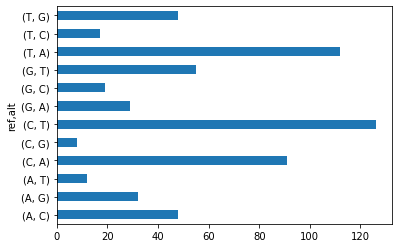

In [30]:
example_dataframe.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')

In [36]:
example_new_ct = example_dataframe[(example_dataframe.ref == 'C') & (example_dataframe.alt == 'T')].sort_values('position')

# Extract only reads for a barcode

In [35]:
# Get edits for barcode

example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])

example_old_ct = example[example.contig == contig]


# Which overlap?

example_new_ct.index = example_new_ct.position
example_old_ct.index = example_old_ct.start
overlapping = example_old_ct.join(example_new_ct, rsuffix='_2', how='inner').drop_duplicates()
print("Number of sites in old version: {}".format(len(example_old_ct)))
print("Number of sites recapitulated: {}".format(len(overlapping)))

Number of sites in old version: 11
Number of sites recapitulated: 11
